# 転写説明用

**基本的な流れ**
1. 事前準備
2. 画像をモデルに入れる形に変換する
3. Encoderに入力してZsem及びxTを出力
4. Zsemで変化ベクトルを求める
5. Decoderに入力して結果を出力
6. 結果を保存

## 1. 事前準備

モジュールの自動リロード

In [1]:
%load_ext autoreload
%autoreload 2

モジュールの読み込み  
カレントディレクトリにある（templates.pyなど）

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

C:\Users\shing\Python\research\test\diffae_test\metrics.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


モデルの作成・読み込み

In [3]:
# gpuの指定
device = 'cuda:0'
conf = ffhq256_autoenc()
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 160.69 M


## 2. 画像をモデルに入れる形に変換

画像フォルダの確認

In [5]:
# 画像フォルダのパスを指定
img_dir_src = 'test/crop/yotaka_default-yotaka_smile'
for i,file in enumerate(os.listdir(img_dir_src)):
    print(f'{i}: {file}')

0: all_from.png
1: all_to.png
2: eye2_from.png
3: eye2_mouth_from.png
4: eye2_mouth_to.png
5: eye2_to.png
6: face_from.png
7: face_to.png
8: mouth_from.png
9: mouth_nose_from.png
10: mouth_nose_to.png
11: mouth_to.png
12: pose_from.png
13: pose_to.png


In [6]:
# 画像フォルダのパスを指定
img_dir_tgt = 'imgs_align'
for i,file in enumerate(os.listdir(img_dir_tgt)):
    print(f'{i}: {file}')

0: azuki_default.png
1: ceo_default.png
2: check1.png
3: check2.png
4: danda_default.png
5: detective.png
6: detective_02.png
7: mio_happy.png
8: mio_shock.png
9: mio_silence.png
10: mio_u.png
11: nanko_default.png
12: ookawa_angry.png
13: ookawa_angry2.png
14: ookawa_default.png
15: ookawa_high.png
16: ookawa_regret.png
17: ookawa_smile.png
18: ookawa_surprised.png
19: pharmacist.png
20: saki.png
21: saki_glasses.png
22: sandy.png
23: takebe_default.png
24: test01.png
25: test01_02.png
26: test01_03.png
27: test01_04.png
28: woman_default.png
29: yotaka_angry.png
30: yotaka_angry2.png
31: yotaka_bald.png
32: yotaka_bushy.png
33: yotaka_default.png
34: yotaka_gj.png
35: yotaka_smile.png
36: yotaka_smile2.png


画像の変換

**ImageDataset**  
以下の様に変更  
- 画像サイズを256×256  
- (N,C,H,W)=(画像の枚数, チャネル, 高さ, 幅)  
- torch.FloatTensor[0.0, 1.0]  
- μ=0.5, Σ=0.5で標準化 → [-1.0, 1.0]  

In [9]:
# img_dirのとこに画像のパスを書く
data_src = ImageDataset(img_dir_src, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
# 転写元(src)の選択
# 上のインデントで選択
batch_src = torch.stack([
    data_src[0]['img'],
    data_src[1]['img']
])

data_tgt = ImageDataset(img_dir_tgt, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)

# 転写先(tgt)の選択
batch_tgt = torch.stack([
    data_tgt[0]['img'],
    data_tgt[11]['img'],
    data_tgt[24]['img'],
])

画像の表示

**permute([1,2,0])/2+0.5**  
- 次元操作(H,W,C)に変換  
- [0, 1]にスケーリング

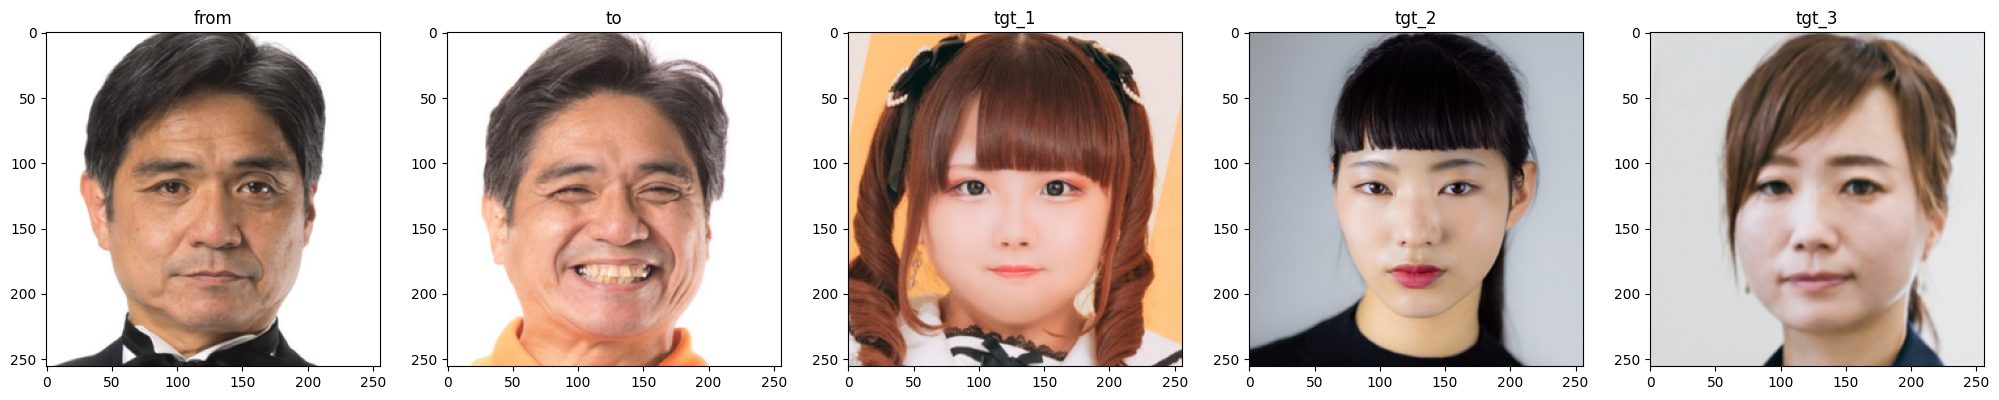

In [10]:
import matplotlib.pyplot as plt

num_tgt = len(batch_tgt)
fig, ax = plt.subplots(1, num_tgt+2, figsize=(5*(num_tgt+2), 5))
ax[0].imshow(batch_src[0].permute([1, 2, 0]) / 2 + 0.5)
ax[0].set_title(f"from")
ax[1].imshow(batch_src[1].permute([1, 2, 0]) / 2 + 0.5)
ax[1].set_title(f"to")

for i in range(num_tgt):
    ax[i+2].imshow(batch_tgt[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i+2].set_title(f"tgt_{i+1}")

## 3. Encoderに入力してZsem及びxTを出力

### Semantic Encoder(画像) → Zsem  
- **model.encode(batch.to(device))**    
Zsemは512次元の潜在空間  
画像は複数枚でも1枚でも必ず(N, C, H, W)で入力する  
入力する際は .to(device) でgpu処理させる  
出力するZsemは(N, 512)の形式

In [11]:
# 転写元(src)のZsem(cond)を得る
cond_src = model.encode(batch_src.to(device))

# 転写先(tgt)のZsemを得る
cond_tgt = model.encode(batch_tgt.to(device))

### Stochastic Encoder(画像, Zsem) → xT
- **model.encode_stochastic(batch.to(device), cond, T=250)**    
画像は(N, C, H, W)で入力  
Zsemは(N, 512)で入力  
Tはステップ数(基本変えないでいい)  
出力するxTは(N, C, H, W)の形式

In [12]:
# tgtのxTを得る
xT = model.encode_stochastic(batch_tgt.to(device), cond_tgt, T=250)

オリジナル画像とxTの比較

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


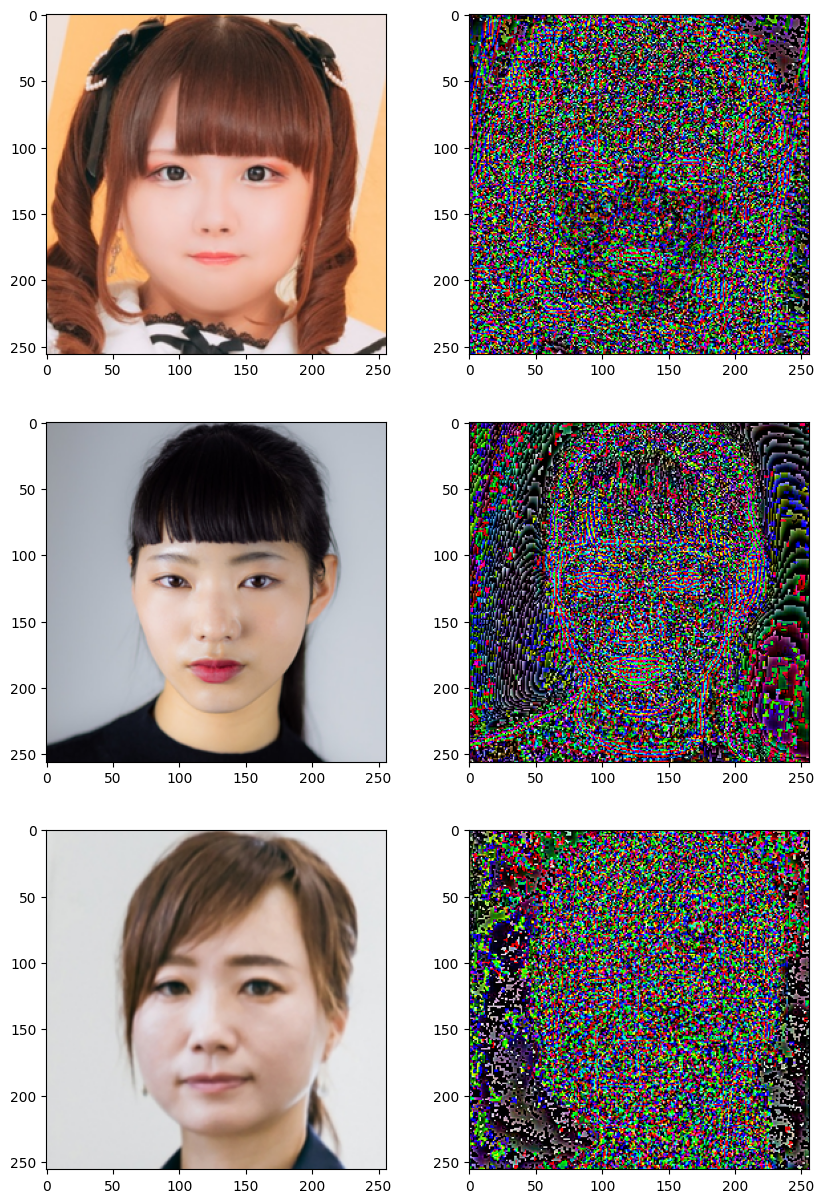

In [13]:
num_xT = len(xT)
fig, ax = plt.subplots(num_xT, 2, figsize=(10, 5*num_xT))
ori = (batch_tgt + 1) / 2
for i in range(num_xT):
    # .cpu()でcpuに渡す. ※gpuに渡したのは表示できない
    ax[i,0].imshow(ori[i].permute(1, 2, 0))
    ax[i,1].imshow(xT[i].permute(1, 2, 0).cpu())

## 4. Zsemで変化ベクトルを求める

In [14]:
# 変化ベクトル(差分)を求める
cond_change = cond_src[1] - cond_src[0]
# 変化の大きさ
alp = 1
# tgtに変化ベクトルを足す(Zsem空間上)
cond = cond_tgt + alp * cond_change

## 5. Decoderに入力して結果を出力

### Decoder(xT, Zsem) → 画像
- **model.render(xT, cond, T=20)**  
xTは(N, C, H, W)  
Zsemは(N, 512)  
Tは基本変えなくていい  
出力する画像は(N, C, H, W)

In [15]:
# Decoderにかける
pred = model.render(xT, cond, T=20)

オリジナル画像と出力した画像の比較

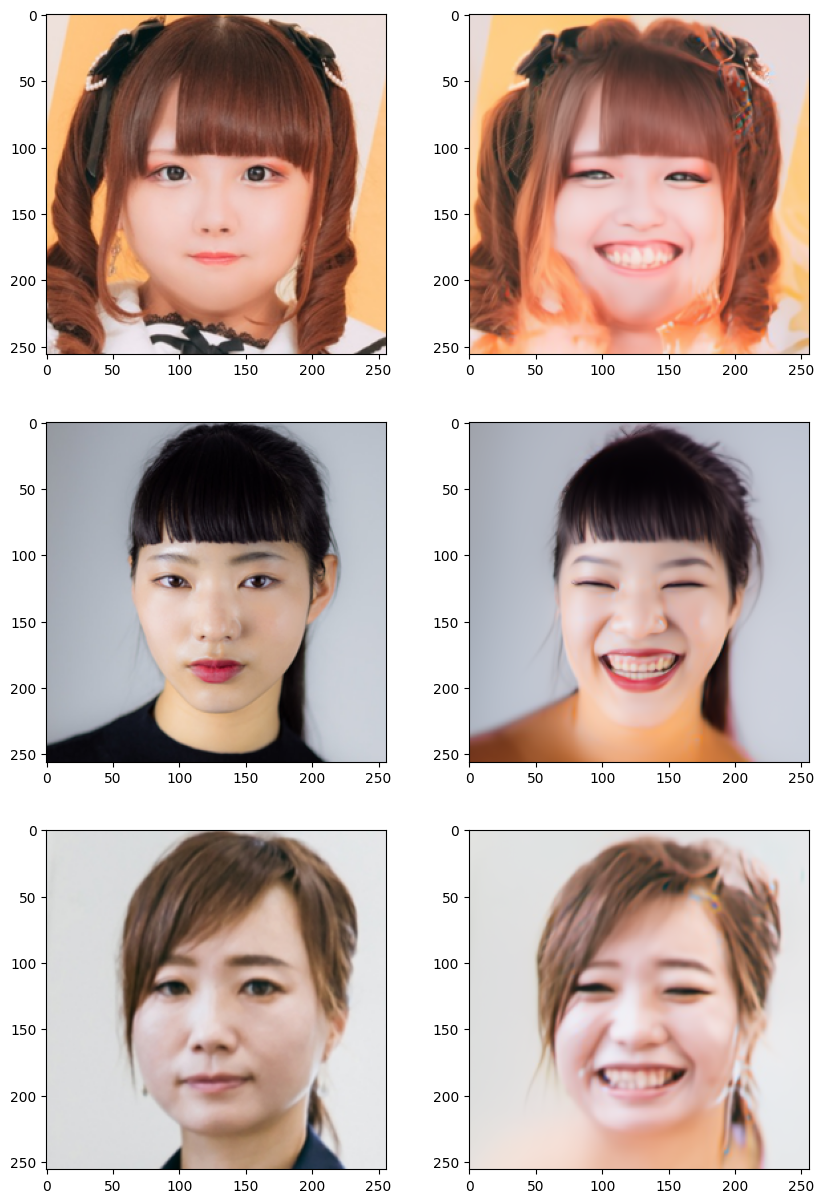

In [16]:
num_pred = len(pred)
fig, ax = plt.subplots(num_pred, 2, figsize=(10, 5*num_pred))
ori = (batch_tgt + 1) / 2
for i in range(num_pred):
    ax[i,0].imshow(ori[i].permute(1, 2, 0))
    ax[i,1].imshow(pred[i].permute(1, 2, 0).cpu())

## 6. 結果を保存

In [17]:
# 保存先フォルダ
dst_dir = f"test/results/"
# 保存先フォルダが存在しなかったら作成する
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
# 保存(tensor画像)
save_image(pred[2], dst_dir+"smile3.png", format='PNG')

## Ex. 変化推移gifの作成

In [18]:
# 等差数列を作成
alp = torch.tensor(np.linspace(0, 1, 11, dtype=np.float32)).to(device)

# 変化ベクトルを足す
# [:,None]で後ろに次元を追加
# [None]だと先頭に次元を追加
cond = cond_tgt[0] + alp[:,None] * cond_change
pred = model.render(xT[0].repeat(len(alp),1,1,1), cond, T=20)

**forを使った方法**  
一度に入れすぎるとメモリが足りなくなる場合があるから  
こっちの方が良いかも

In [19]:
alp = torch.tensor(np.linspace(0, 1, 11, dtype=np.float32)).to(device)
cond = cond_tgt[1] + alp[:,None] * cond_change
pred = []
for c in cond:
    pred.append(model.render(xT[1,None], c[None], T=20)[0])
    
# tensorに変換(やらなくてもいい)
pred = torch.stack(pred)

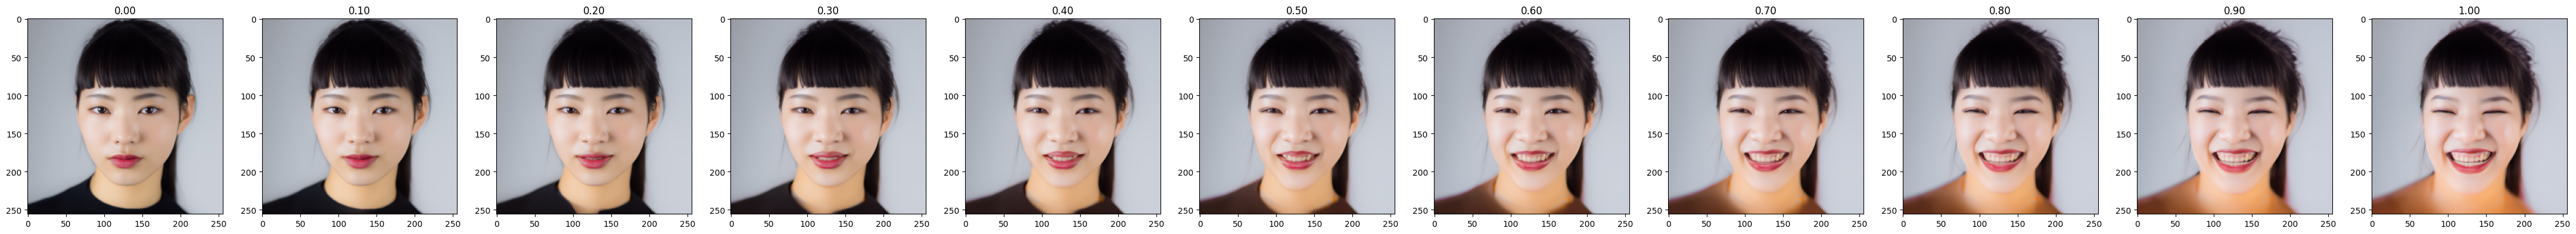

In [20]:
num_pred = len(pred)
fig, ax = plt.subplots(1, num_pred, figsize=(5*num_pred, 5))
for i in range(num_pred):
    ax[i].imshow(pred[i].permute(1, 2, 0).cpu())
    ax[i].set_title(f'{alp[i].item():.2f}')

**Image.fromarray()**  
配列からpilを作成する関数  

In [21]:
from PIL import Image

pred_pil = []
for p in pred:
    # [0,1]float → [0,255]intに変換
    p = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
    pred_pil.append(Image.fromarray(p))

gifの保存

In [22]:
# 保存先
dst_dir = "test/results/"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

pred_pil[0].save(
    dst_dir+"smile.gif",   # 保存先のパス
    format="gif",
    save_all=True,
    append_images=pred_pil,
    duration=4000//(len(pred_pil)),
    loop=0)